# Autocorrelation Layer

In [ ]:
class PreviousInputLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PreviousInputLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Trainable weight for rho
        self.rho = self.add_weight(shape=(),
                                   initializer='zeros',
                                   trainable=True,
                                   name='rho')

        # Non-trainable variable to store previous input
        # Use input_shape[-1] to define the shape, excluding the batch dimension
        self.previous_input = self.add_weight(shape=(input_shape[-1],),
                                              initializer='zeros',
                                              trainable=False,
                                              name='previous_input')

    def call(self, inputs, training=False):
        # Update previous input only during training
        if training:
            # Update the previous_input with the last batch's inputs
            self.previous_input.assign(inputs[-1])

        # Expand the dimensions of previous_input to match inputs
        expanded_previous_input = tf.expand_dims(self.previous_input, 0)

        # Calculate the modified input
        modified_input = inputs - self.rho * expanded_previous_input
        return modified_input


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model

class T2V(Layer):
    def __init__(self, output_dim, **kwargs):
        super(T2V, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        # Initialize weights
        self.w = self.add_weight(name='t2v_w', shape=(input_shape[-1], self.output_dim),
                                 initializer='uniform',
                                 trainable=True)
        self.p = self.add_weight(name='t2v_p', shape=(input_shape[-1], self.output_dim),
                                 initializer='uniform',
                                 trainable=True)

    def call(self, inputs):
        # Linear part
        linear = tf.matmul(inputs, self.w)

        # Periodic part
        periodic = tf.sin(tf.matmul(inputs, self.p))

        # Concatenation operation
        return tf.concat([linear, periodic], axis=-1)

In [ ]:
class RhoCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(RhoCallback, self).__init__()
        self.layer = layer
        self.rho_values = []  # List to store the rho values

    def on_epoch_end(self, epoch, logs=None):
        rho_value = self.layer.rho.numpy()
        self.rho_values.append(rho_value)  # Append the current value of rho
        print(f"Epoch {epoch + 1}: rho = {rho_value}")


In [ ]:
# Build Model 2: Single Dense Layer on Concatenated Output
def build_model_single_dense_layer(input_shape, t2v_output_dim, dense_units):
    inputs = Input(shape=input_shape, name='input_layer')

    # Custom layer
    previous_input_layer = PreviousInputLayer(name='previous_input_layer')
    modified_input = previous_input_layer(inputs)

    # Apply T2V
    t2v_output = T2V(t2v_output_dim, name='t2v_layer')(inputs)

    # Single dense layer
    dense_output = Dense(dense_units, activation='relu', name='dense_layer_1')(t2v_output)
    dropout = tfkl.Dropout(0.1, name='dropout')(dense_output)
    #dense_output_2 = Dense(dense_units/2, activation='relu', name='dense_layer_2')(dropout)
    #dropout_2 = tfkl.Dropout(0.15, name='dropout_2')(dense_output_2)
    final_output = Dense(18, activation='linear', name='output_layer')(dropout)  # Adjust the final output size as needed

    model = Model(inputs=inputs, outputs=final_output, name='t2v_single_dense_model')
    return model, previous_input_layer



In [ ]:
# Example usage
predicted_window_dim = 36
input_shape = (200,)
dense_units = 256

# Build the model and get the custom layer
autocorrelation, previous_input_layer = build_model_single_dense_layer(input_shape, predicted_window_dim, dense_units)

autocorrelation.summary()
# Compile the model again after modifying the trainable status of the layers
autocorrelation.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3))

Model: "t2v_single_dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 t2v_layer (T2V)             (None, 72)                14400     
                                                                 
 dense_layer_1 (Dense)       (None, 256)               18688     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output_layer (Dense)        (None, 18)                4626      
                                                                 
Total params: 37714 (147.32 KB)
Trainable params: 37714 (147.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from sklearn.preprocessing import RobustScaler
epochs = 1000
batch_size = 8

# Instantiate the custom callback
rho_callback = RhoCallback(previous_input_layer)


# Example usage
predicted_window_dim = 36
input_shape = (200,)
dense_units = 256


# Train the model
history = autocorrelation.fit(
    x=X_train['Mixed'],
    y=Y_train['Mixed'],
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_val['Mixed'], Y_val['Mixed']),
    callbacks=[rho_callback,
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, min_delta = 0.0001, restore_best_weights=True),
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.5, min_lr=1e-4)]
)


Epoch 1/1000
747/747 [==============================] - 5s 4ms/step - loss: 0.0168 - val_loss: 0.0105 - lr: 0.0010
Epoch 2/1000
747/747 [==============================] - 3s 4ms/step - loss: 0.0113 - val_loss: 0.0097 - lr: 0.0010
Epoch 3/1000
747/747 [==============================] - 4s 5ms/step - loss: 0.0107 - val_loss: 0.0096 - lr: 0.0010
Epoch 4/1000
747/747 [==============================] - 4s 5ms/step - loss: 0.0104 - val_loss: 0.0092 - lr: 0.0010
Epoch 5/1000
747/747 [==============================] - 3s 4ms/step - loss: 0.0101 - val_loss: 0.0097 - lr: 0.0010
Epoch 6/1000
747/747 [==============================] - 3s 4ms/step - loss: 0.0099 - val_loss: 0.0088 - lr: 0.0010
Epoch 7/1000
747/747 [==============================] - 3s 4ms/step - loss: 0.0097 - val_loss: 0.0088 - lr: 0.0010
Epoch 8/1000
747/747 [==============================] - 4s 5ms/step - loss: 0.0096 - val_loss: 0.0085 - lr: 0.0010
Epoch 9/1000
747/747 [==============================] - 3s 4ms/step - loss: 0.00

In [ ]:
# Store the rho values after training
rho_values = rho_callback.rho_values
rho_values

[0.026468141,
 0.015159184,
 0.019090692,
 0.011134539,
 0.013118601,
 0.006068041,
 0.011997416,
 0.0069823074,
 0.0103153195,
 -0.00093305553,
 0.006981764,
 0.0068889647,
 0.005002275,
 0.0063580424,
 0.005511642,
 0.008479783,
 0.010653649,
 0.007257745,
 0.008754687,
 0.0046624644,
 0.0031297982,
 0.0033460734,
 0.004481682,
 0.0012125567,
 0.001023674,
 0.0016070139,
 0.0037766474,
 -0.000109049055,
 0.0025610833,
 0.0006190713,
 0.0007497342,
 0.0025724734,
 0.0018361992,
 0.0014265195,
 0.0022370052,
 0.0017836582,
 0.0024350279,
 0.0019074156,
 0.0018989358,
 -0.00060005934,
 0.0026190805,
 0.0042017824,
 0.0014590622]

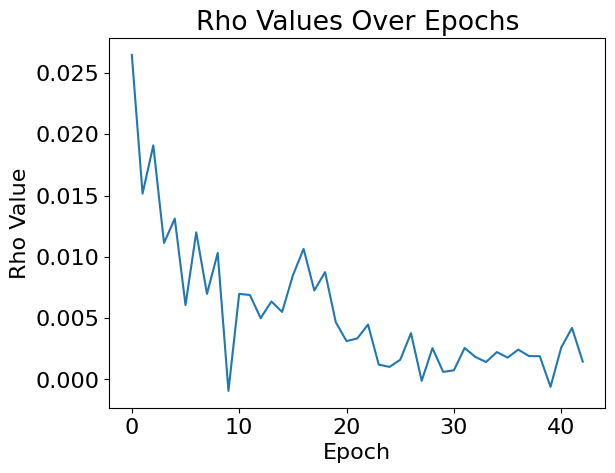

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rho_values)
plt.title('Rho Values Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Rho Value')
plt.show()
